In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
from sklearn.decomposition import PCA
from datetime import datetime
date_format = '%Y-%m-%d' # This depend on the data
#date_format = '%Y-%m-%d %H:%M:%S'
from scipy import optimize
from functools import reduce

In [3]:
# Function to covert datestrings to datetime objects (useful for plotting)
def to_datetime(date_string):
    if type(date_string) == str:
        return datetime.strptime(date_string,date_format)
    else:
        return date_string

class AssetClass():
    
    # Generally takes in a pandas dataframe with a date column and multiple 'value' string type columns
    # Values can be NaN
    
    window_size = 90
    stride_size = 1
    #date_column = 'Date'
    
    
    def __init__(self,df,date_column='date'):
        
        self.date_column = date_column
        self.dates = df[self.date_column].apply(to_datetime).values # Extract date column as array of datetimes
        self.values = df.drop(columns=[self.date_column])
        self.values = self.values.astype('float')
        self.log_returns = self.calc_log_returns()
        self.ratios = self.calc_pca_ratios()
        
        self.dates = self.dates[len(self.dates)-len(self.ratios):]
        self.values = self.values.values[len(self.values)-len(self.ratios):]
        self.mean = np.nanmean(self.values,axis=1)
        self.log_returns = self.log_returns[len(self.log_returns)-len(self.dates):]
        self.first_ratios = np.transpose(self.ratios)[0] # Get 1d array of 1st ratios in each PCA
        self.lambs = self.calc_lambs()  # Fit exponential distribution to each row of self.ratios
                                        # Collect array of best fit parameters

    def calc_log_returns(self):
        
        log_returns = pd.DataFrame()
        
        for index_name in self.values.columns:
            log_returns[index_name] = np.log(self.values[index_name]) - np.log(self.values[index_name].shift(1))
        
        log_returns = log_returns[1:]

        return log_returns.values
        
    def calc_pca_ratios(self):
        
        data = self.log_returns
        ratios = None

        N = len(data)
        i = 0
        j = i + self.window_size

        pca = PCA()

        while j <= N:

            X = data[i:j,:]
            X = X[:,~np.isnan(X).any(axis=0)]
            
            pca.fit(X)
            
            if ratios is None:
                ratios = pca.explained_variance_ratio_
            else:
                ratios = np.vstack((ratios,pca.explained_variance_ratio_))

            i += self.stride_size
            j += self.stride_size
            
        return ratios
    
    
    def calc_lambs(self):
        lambs = np.array([])
        x = np.arange(0,self.ratios.shape[1])
        
        def pdf(x,lamb):
            return lamb*np.exp(-lamb*x)
        
        for y in self.ratios:
            lamb = optimize.curve_fit(pdf,x,y)[0]
            lambs = np.append(lambs,lamb)
            
        return lambs
        
    def plot_first_ratios(self):
        plt.plot(self.dates,self.first_ratios) 
        plt.xlabel('Year')
        plt.ylabel('Variance Explained by 1st PC')
        plt.title('90 tailing window, 1 day stride')
        plt.suptitle('Rolling PCA',fontsize=14)
        plt.show()
        
    def plot_values(self):
        plt.plot(self.dates,self.values[:,]) 
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.title('Index Value over time')
        plt.show()
        
    def plot(self):
        data1 = self.first_ratios
        data2 = self.mean
        t = self.dates#[-data1.shape[0]:]

        fig, ax1 = plt.subplots()

        color = 'tab:orange'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Ratio of first PC', color=color)
        ax1.plot(t, data1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('Average Value', color=color)  # we already handled the x-label with ax1
        ax2.plot(t, data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped

        plt.show()

# Using AssetClass

In [5]:
# Read in csv of financial data
filename = "/Users/theo/Documents/RiskLab/Asset Allocation Strategies/S&P.csv" #Change this
data = pd.read_csv(filename)
data.drop(columns=['Date'],inplace=True) # There are two date columns in the S&P dataframe right now

/Users/theo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


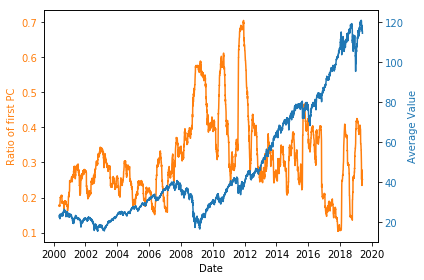

In [7]:
spy = AssetClass(data,date_column='date') # Instantiate AssetClass for the financial data
spy.plot() # This plots the first PC ratios and the average values for the assets

In [8]:
# Read in other data
root = "/Users/theo/Documents/RiskLab/Asset Allocation Strategies/FinEmbed-master/"
commodities = pd.read_csv(root+"DF_Commodities.csv")
crypto = pd.read_csv(root+"DF_Crypto.csv")
equities = pd.read_csv(root+"DF_Equities.csv")
fixed = pd.read_csv(root+"DF_FixedIncome.csv")
hedge = pd.read_csv(root+"DF_HedgeFunds.csv")

In [9]:
# This joins all the data into one dataframe
dfList = [commodities,crypto,equities,fixed,hedge]
all_assets = reduce(lambda x, y: pd.merge(x, y, on = 'Date'), dfList)

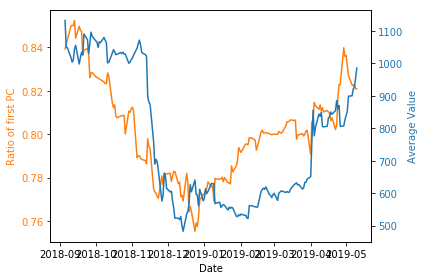

In [14]:
crypto = AssetClass(crypto,'Date')
crypto.plot()

# Taking a shot at clustering

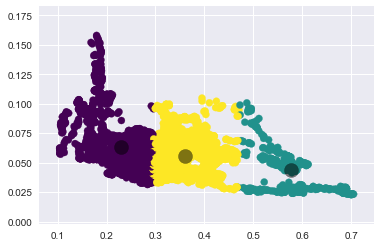

In [15]:
%matplotlib inline
import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans
X = spy.ratios[:,:2]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### The vertical lines separating the clusters is Kmeans way of saying it only cares about the first eigen value. I guess we shouldnt be surprised.